In [33]:
import poppy
import copy
import pickle
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from skimage.transform import resize
from poppy.poppy_core import PlaneType

In [34]:
#!/usr/bin/env python
# coding: utf-8

%matplotlib qt

In [35]:
## BEGIN USER-DEFINED QUANTITIES

# initial focal length of lens (um) in the substrate
#f_lens_substr = 284.664*u.micron
f_lens_substr = 400.*u.micron

# pixel scale of 'detector' (plane of waveguide entrance)
scale_wg = 0.2161*u.micron/u.pix

# lenslet diameter
diam_lenslet = 66.*u.micron

# index of refraction of substrate
n_glass = 1.5255

## LOOP THIS
# wavelength in air (n = 1)
wavel_air = 1.55*u.micron

## END USER-DEFINED QUANTITIES

Radius of first dark Airy ring (um): 10.329946465639681 micron
Waveguide mode spatial shape: (<Quantity 200. micron>, <Quantity 200. micron>)
Waveguide mode pixel shape: (200, 200)
distance: 501.0160603080957 micron


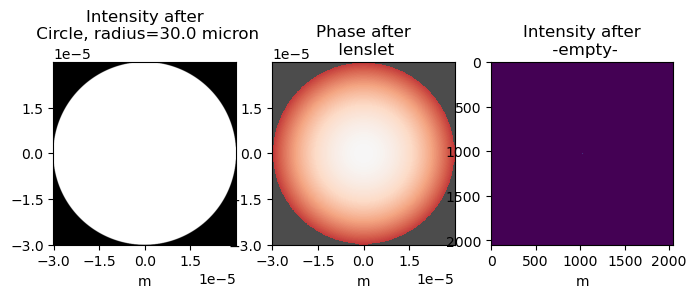

In [12]:
# derived quantities

# wavelength in substrate
wavel_substr = (wavel_air/n_glass)

# radius of first dark ring in um
circ_r_um = 1.22 * wavel_substr * f_lens_substr/diam_lenslet

print('Radius of first dark Airy ring (um):',circ_r_um)

# read in waveguide mode

'''
S. Gross:

The waveguide modes have a 4sigma diameter of 8.3x7.6um. 
A simple Gaussian fit gives a 1/e2 diameter of 5.8x5.4um. 
Both at a wavelength of 1550nm.

The attached CSV file contains the corresponding intensity profile. 
The scale is 0.2161um per pixel.
'''

# retrieve waveguide intensity and make cutout
stem = '/Users/bandari/Documents/git.repos/glint_misc/notebooks/data/'
open_file = open(stem + 'AF45_100x_Zeiss_300um_1550nm_1000mmmin_67pt5nJ_csv.pkl', "rb")
df_intensity, xycen = pickle.load(open_file)
open_file.close()
# cutouts
buffer = 100 # pix
waveguide_cutout = df_intensity[int(xycen[1]-buffer):int(xycen[1]+buffer),int(xycen[0]-buffer):int(xycen[0]+buffer)]


# physical dims of waveguide pattern
x_dim_waveguide, y_dim_waveguide = np.multiply(np.shape(waveguide_cutout),scale_wg*u.pixel)

print('Waveguide mode spatial shape:',(x_dim_waveguide,y_dim_waveguide))
print('Waveguide mode pixel shape:',np.shape(waveguide_cutout))

# for secondary physical axes: 0.2161um per pixel.
def pix2um(x):
    return x*0.2161

def um2pix(x):
    return x/0.2161

# construct Fresnel system with lens of focal length f um and project image

npix = 1024 # ~512 is minimum to accurately recover the central diffraction spike

steps_one_side = 10 # number of steps on one side of zero focus
overl_int_array = np.nan*np.ones(int(2*steps_one_side)) # will collect overlap integrals
defocus_values_array = np.nan*np.ones(int(2*steps_one_side)) # will collect defocus values (ito waves)
idx_accum = 0 # initialize index

## LOOP THIS
for step_foc in range(10,11): #-int(steps_one_side),int(steps_one_side)):
    
    NWAVES = step_foc*0.1 # size of defocus ito waves

    ## LOOP THIS
    z = f_lens_substr + NWAVES*wavel_substr # propagation distance
    #z = 0

    # BEGIN METHOD WITH OPTICAL SYSTEM
    
    opt_sys = poppy.FresnelOpticalSystem(pupil_diameter=diam_lenslet, npix=512, beam_ratio=0.25)
    ap = poppy.CircularAperture(radius=0.5*diam_lenslet)
    m1 = poppy.QuadraticLens(f_lens=f_lens_substr, name='lenslet')
  
    opt_sys.add_optic(ap, distance=0*u.micron)
    opt_sys.add_optic(m1, distance=0*u.micron)

    #opt_sys.add_detector(pixelscale=scale_wg, fov_pixels=200, distance=z)
    
    #opt_sys.describe()
    opt_sys.add_optic(poppy.ScalarTransmission(transmission=1.0), distance=z)

    print('distance:',z)
    plt.figure(figsize=(8,6))
    psf, waves = opt_sys.calc_psf(wavelength=wavel_substr, display_intermediates=True, return_intermediates=True)
    # handy
    # plt.imshow(psf[0].data,norm='log')
    
    plt.imshow(psf[0].data)

    #plt.clf()
    '''
    plt.imshow(waves[-1].intensity,norm='log')
    plt.colorbar()
    plt.savefig('junk_'+f'{idx_accum:02d}'+'.png')
    '''
    # END METHOD WITH OPTICAL SYSTEM
    idx_accum += 1

    ''' # BEGIN METHOD WITHOUT USING SYSTEM
    ap = poppy.CircularAperture(radius=0.5*diam_lenslet) 
    wf = poppy.FresnelWavefront(beam_radius=0.5*diam_lenslet, wavelength=wavel_substr, npix=npix, oversample=4) # oversample=10 ORIGINAL COMMAND
    #wf = poppy.FresnelWavefront(beam_radius=1*u.m, wavelength=wavel_substr, npix=npix, oversample=4) # oversample=10
    import ipdb; ipdb.set_trace()
    wf *= ap
    print("After aperture, beam waist is at {}".format(wf.z_w0) )

    conv_lens = poppy.QuadraticLens(f_lens=f_lens_substr)
    #conv_lens = poppy.QuadraticLens(f_lens=1.*u.micron)
    #conv_lens = poppy.QuadraticLens(f_lens=1.*u.m)
    wf *= conv_lens
    print("After lens with focal length {}, beam waist is at {:.2f}".format(conv_lens.fl, wf.z_w0) )
    import ipdb; ipdb.set_trace()

    # propagate over distance z
    wf.propagate_fresnel(z)
    import ipdb; ipdb.set_trace()
    # handy
    # wf.display('intensity',scale='log')
    ''' # END METHOD NOT USING SYSTEM

    '''
    # crop to the physical size of the waveguide cutout by using rectangular aperture
    wf *= poppy.RectangleAperture(width=x_dim_waveguide, height=y_dim_waveguide)
    # remove residual zeros on edges
    x, y = np.nonzero(wf.amplitude)
    xl,xr = x.min(),x.max()
    yl,yr = y.min(),y.max()
    wf_amp_cropped = wf.amplitude[xl:xr+1, yl:yr+1]
    wf_phase_cropped = wf.phase[xl:xr+1, yl:yr+1]

    wf.display('intensity', scale='log', 
            vmax=wf.amplitude.max(), vmin=wf.amplitude.max()*1e-5, 
            imagecrop=10.*circ_r_um)
    import ipdb; ipdb.set_trace()

    # ratio of wf spatial scale to waveguide scale

    scale_wf = wf.pixelscale.to(u.micron/u.pix)

    scale_wf_2_wg = scale_wf/scale_wg

    print('Thickness: ',z)
    print('Raw spatial scale_wf:',scale_wf)
    print('Raw spatial scale_wg:',scale_wg)

    # rescale shape of waveguide mode array

    # >1 means 'waveguide is this much finer than wavefront'
    scale_wf_2_wg = scale_wf/scale_wg
    new_shape_wavefront = np.array(np.shape(wf_amp_cropped)*scale_wf_2_wg).astype(int)

    print('Shape of waveguide cutout:',np.shape(waveguide_cutout))
    print('Sanity check: calculate new shape of rescaled wavefront (should be almost identical to waveguide cutout):',new_shape_wavefront)

    # rescale array of wavefront to match waveguide
    wf_amp_rescaled = resize(wf_amp_cropped,np.shape(waveguide_cutout))
    wf_phase_rescaled = resize(wf_phase_cropped,np.shape(waveguide_cutout))

    # define fields for overlap integral (should just be 200x200 arrays)
    input_field = wf_amp_rescaled * np.exp(1j*wf_phase_rescaled)
    mode_field = np.sqrt(waveguide_cutout) # sqrt because cutout is the intensity I, and we want E

    # overlap integral
    overlap_int_complex = np.sum(input_field*mode_field) / np.sqrt( np.sum(np.abs(mode_field)**2) * np.sum(np.abs(input_field)**2) )
    overlap_int = np.abs(overlap_int_complex)**2

    # print params
    print('Defocus (waves):',NWAVES)
    print('Wavel in substrate (um):',wavel_substr)
    import ipdb; ipdb.set_trace()
    
    
    print('OVERLAP INTEGRAL:',overlap_int)
    print('---------------------')
    
    overl_int_array[idx_accum] = overlap_int
    defocus_values_array[idx_accum] = NWAVES


    ### plotting

    circ_r_pix = um2pix(circ_r_um)/u.micron # divide out units

    circ_cen_x = 0.5*np.shape(wf_amp_rescaled)[0]
    circ_cen_y = 0.5*np.shape(wf_amp_rescaled)[1]

    psf_intensity = np.abs(input_field)**2

    plt.clf()
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,6), layout='constrained')
    ax[0,0].imshow(wf_amp_rescaled, norm='log', origin='lower')
    ax[0,0].set_title('Ampl (log)')
    ax[0,0].add_patch(Circle((circ_cen_x,circ_cen_y),radius=circ_r_pix,color='white',fill=False))

    ax[0,1].imshow(wf_phase_rescaled,norm='linear', origin='lower')
    ax[0,1].set_title('Phase')
    ax[0,1].add_patch(Circle((circ_cen_x,circ_cen_y),radius=circ_r_pix,color='white',fill=False))

    ax[0,2].imshow(psf_intensity,norm='log', origin='lower')
    ax[0,2].set_title('Intensity (log)')
    ax[0,2].add_patch(Circle((circ_cen_x,circ_cen_y),radius=circ_r_pix,color='white',fill=False))

    ax[1,0].imshow(waveguide_cutout, origin='lower')
    ax[1,0].set_title('Waveguide mode I')
    ax[1,0].add_patch(Circle((circ_cen_x,circ_cen_y),radius=circ_r_pix,color='white',fill=False))

    ax[1,1].plot(psf_intensity[100,:]/np.max(psf_intensity))
    ax[1,1].plot(waveguide_cutout[100,:]/np.max(waveguide_cutout))

    plt.tight_layout()

    plt.savefig('junk'+str(step_foc)+'.png')
    #import ipdb; ipdb.set_trace()
    '''
    
    #plt.imshow(waves[-1].intensity,norm='log')
    #plt.show()

In [11]:
step_foc

10

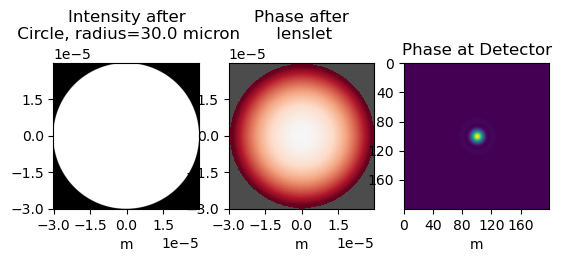

In [8]:
diam_lenslet = 60 * u.micron
f_lens_substr = 500 * u.micron
scale_wg = 1 * u.micron/u.pixel
wavel_substr = 1.55 * u.micron

z=500 * u.micron + wavel_substr

opt_sys = poppy.FresnelOpticalSystem(pupil_diameter=diam_lenslet, npix=512, beam_ratio=0.25)
ap = poppy.CircularAperture(radius=0.5 * diam_lenslet)
m1 = poppy.QuadraticLens(f_lens=f_lens_substr, name='lenslet')

opt_sys.add_optic(ap, distance=0 * u.micron)
opt_sys.add_optic(m1, distance=0 * u.micron)

opt_sys.add_detector(pixelscale=scale_wg, fov_pixels=200, distance=z)
psf, waves = opt_sys.calc_psf(wavelength=wavel_substr, display_intermediates=True, return_intermediates=True)
plt.imshow(psf[0].data)

In [6]:
len(waves)

3

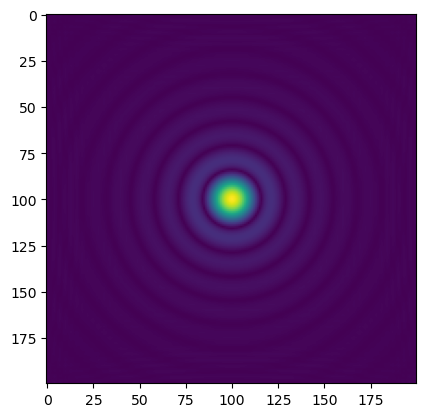

In [9]:
plt.imshow(waves[-1].amplitude)
plt.show()

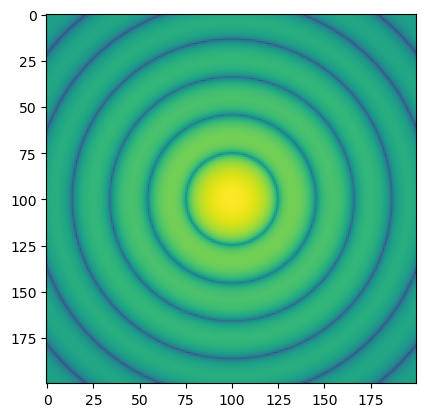

In [42]:
plt.imshow(waves[-1].intensity,norm='log')
plt.savefig('junk_1wavedefocus.png')

In [17]:
waves

In [29]:
diam_lenslet = 60 * u.micron
f_lens_substr = 10 * u.micron
#scale_wg = 1 * u.micron/u.pixel
wavel_substr = 1.55 * u.micron

z = 9 * u.micron + wavel_substr

wf = poppy.FresnelWavefront(beam_radius=4.*diam_lenslet, wavelength=wavel_substr, npix=1024, oversample=4)

#wf = poppy.FresnelWavefront.input_wavefront(beam_radius=4.*diam_lenslet, wavelength=wavel_substr, npix=1024, oversample=4)

opt_sys = poppy.FresnelOpticalSystem(pupil_diameter=diam_lenslet, npix=1024, beam_ratio=0.25)

#opt_sys.input_wavefront(wf)

ap = poppy.CircularAperture(radius=0.5 * diam_lenslet, name='circap')
m1 = poppy.QuadraticLens(f_lens=f_lens_substr, name='lenslet')
dummyplane = poppy.ScalarTransmission(planetype=PlaneType.image, name='dummy')

# circular aperture
opt_sys.add_optic(ap, distance=0 * u.micron)
# lenslet
opt_sys.add_optic(m1, distance=0 * u.micron)

opt_sys.add_optic(dummyplane, distance = f_lens_substr) #f_lens_substr) #0.1*u.micron)

#psf, waves = opt_sys.calc_psf(wavelength=wavel_substr, display_intermediates=True, return_intermediates=True)

#print(type(wf))

opt_sys.propagate(wf)

psf, wfs = opt_sys.calc_psf(return_intermediates=True, display_intermediates=True)

#test.display('intensity', imagecrop=40000*u.arcsec)

In [42]:
diam_lenslet = 60 * u.micron
f_lens_substr = 400 * u.micron
wavel_substr = 1.55 * u.micron

z = f_lens_substr

opt_sys = poppy.FresnelOpticalSystem(pupil_diameter=diam_lenslet, npix=512, beam_ratio=0.25)
ap = poppy.CircularAperture(radius=0.5*diam_lenslet)
m1 = poppy.QuadraticLens(f_lens=f_lens_substr, name='lenslet')

opt_sys.add_optic(ap, distance=0*u.micron)
opt_sys.add_optic(m1, distance=0*u.micron)
opt_sys.add_detector(pixelscale=scale_wg, fov_pixels=200, distance=z)
psf, waves = opt_sys.calc_psf(wavelength=wavel_substr, display_intermediates=True, return_intermediates=True)

In [24]:
len(wfs)

3

In [43]:
#plt.imshow(waves[2].intensity, norm='linear')
plt.imshow(waves[-1].intensity, norm='log')
plt.show()

In [37]:
test.describe

AttributeError: 'FresnelWavefront' object has no attribute 'describe'

In [61]:
test.display_psf()

AttributeError: 'FresnelWavefront' object has no attribute 'display_psf'

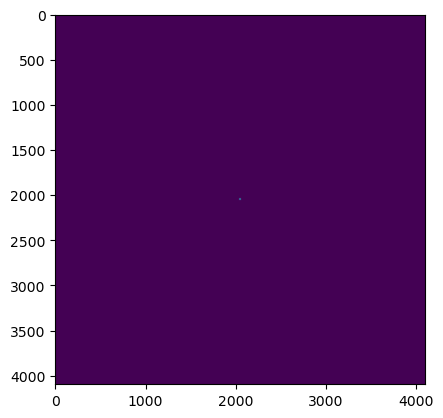

In [58]:
plt.imshow(test.intensity)
plt.show()

In [56]:
test[-1].display('intensity', colorbar=True, scale='log')

TypeError: 'FresnelWavefront' object is not subscriptable

<Axes: title={'center': 'Intensity at Detector'}, xlabel='m'>

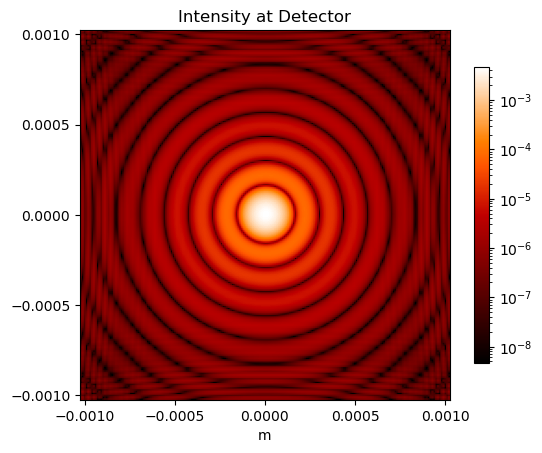

In [55]:
waves[-1].display('intensity', colorbar=True, scale='log')

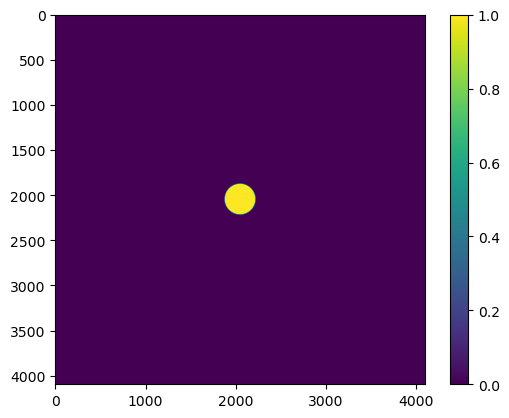

z: 201.55 micron


In [49]:
plt.imshow(test.intensity)
plt.colorbar()
plt.show()
print('z:',z)

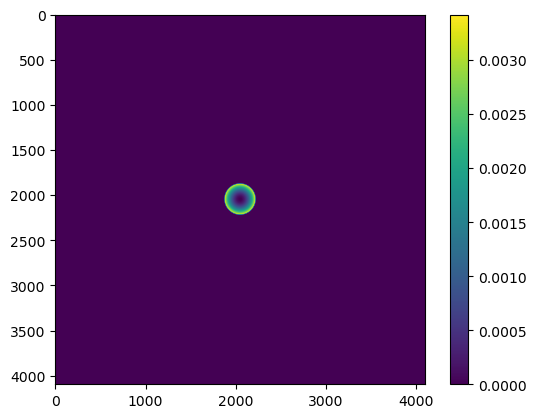

In [45]:
plt.imshow(test.phase)
plt.colorbar()
plt.show()
print('z:',z)

In [61]:
ap = poppy.CircularAperture(radius=0.5*diam_lenslet) 
wf = poppy.FresnelWavefront(beam_radius=0.5*diam_lenslet, wavelength=wavel_substr, npix=npix, oversample=4) # oversample=10 ORIGINAL COMMAND
#wf = poppy.FresnelWavefront(beam_radius=1*u.m, wavelength=wavel_substr, npix=npix, oversample=4) # oversample=10

wf *= ap

print("After aperture, beam waist is at {}".format(wf.z_w0) )

conv_lens = poppy.QuadraticLens(f_lens=f_lens_substr)

wf *= conv_lens

print("After lens with focal length {}, beam waist is at {:.2f}".format(conv_lens.fl, wf.z_w0) )



# propagate over distance z
wf.propagate_fresnel(z)
import ipdb; ipdb.set_trace()
# handy
# wf.display('intensity',scale='log')

After aperture, beam waist is at 0.0 m
After lens with focal length 0.0005 m, beam waist is at 0.00 m
--Call--
> /Users/bandari/anaconda3/envs/glint_env/lib/python3.10/site-packages/IPython/core/displayhook.py(258)__call__()
    257 
--> 258     def __call__(self, result=None):
    259         """Printing with history cache management.

ipdb> c


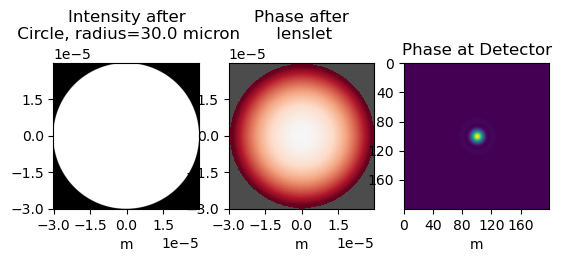

In [18]:
diam_lenslet = 60 * u.micron
f_lens_substr = 500 * u.micron
scale_wg = 1 * u.micron/u.pixel
wavel_substr = 1.55 * u.micron

z=500 * u.micron + wavel_substr

wf = 

opt_sys = poppy.FresnelOpticalSystem(pupil_diameter=diam_lenslet, npix=512, beam_ratio=0.25)
ap = poppy.CircularAperture(radius=0.5 * diam_lenslet)
m1 = poppy.QuadraticLens(f_lens=f_lens_substr, name='lenslet')

opt_sys.add_optic(ap, distance=0 * u.micron)
opt_sys.add_optic(m1, distance=0 * u.micron)

opt_sys.add_detector(pixelscale=scale_wg, fov_pixels=200, distance=z)
psf, waves = opt_sys.calc_psf(wavelength=wavel_substr, display_intermediates=True, return_intermediates=True)
plt.imshow(psf[0].data)

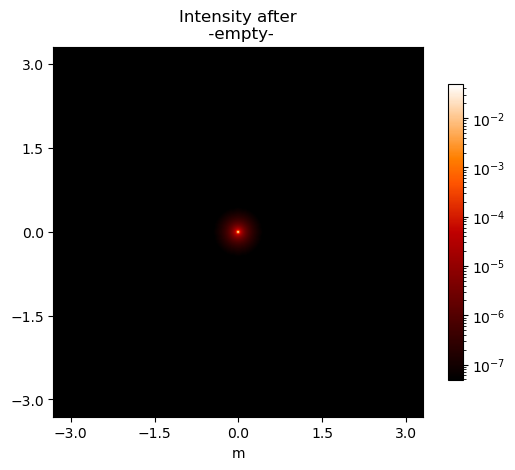

In [60]:
z=0.5*u.m #500 * u.micron #+ wavel_substr

opt_sys = poppy.FresnelOpticalSystem(pupil_diameter=diam_lenslet, npix=512, beam_ratio=0.25)
ap = poppy.CircularAperture(radius=0.5 * diam_lenslet)
#m1 = poppy.QuadraticLens(f_lens=f_lens_substr, name='lenslet')

opt_sys.add_optic(ap, distance=0 * u.micron)
#opt_sys.add_optic(m1, distance=0 * u.micron)

# opt_sys.add_detector(pixelscale=scale_wg, fov_pixels=200, distance=z)
opt_sys.add_optic(poppy.ScalarTransmission(), distance=z)

waves = opt_sys.propagate(wf)

#psf, waves = opt_sys.calc_psf(wavelength=wavel_substr, display_intermediates=True, return_intermediates=True)

for idx_wave in range(0,len(waves)):
    waves[idx_wave].display('intensity', colorbar=True, scale='log')

(<Axes: title={'center': 'Wavefront amplitude'}, xlabel='m', ylabel='m'>,
 <Axes: title={'center': 'Wavefront phase'}, xlabel='m'>)

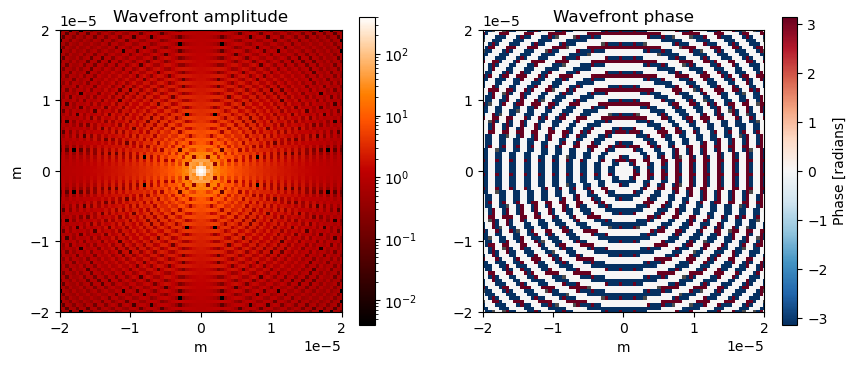

In [56]:
ap = poppy.CircularAperture(radius=1)
wf = poppy.FresnelWavefront(beam_radius=1*u.m, wavelength=1e-6)
wf *= ap

conv_lens = poppy.QuadraticLens(1.0*u.m)
wf *= conv_lens

wf.propagate_fresnel(0.5*u.m)


div_lens = poppy.QuadraticLens(-1*u.m)
wf *= div_lens

wf.propagate_fresnel(wf.z_w0 - 0.5*u.m)


plt.figure(figsize=(10,5))
wf.display('both', colorbar=True, imagecrop=4e-5, scale='log', 
           vmax=wf.amplitude.max(), vmin=wf.amplitude.max()*1e-5)
#plt.suptitle("Wavefront at focus of lens", fontsize=18);

In [47]:
wf.z_w0

<Quantity 1.5 m>